Training snake game (created using pygame) using Deep-Q Learning algorithm .

This consists of four parts Model, Helper code, Agent Class , Game
Importing Necessary Libraries below

In [28]:
#that are required for Agent
import torch
import random
import numpy as np
from collections import deque  #deque is for storing agents rewards, actions , states, next states

#that are required for Model
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os

#Importing Pygame
import pygame
import random
from enum import Enum
from collections import namedtuple
import numpy as np


Helper code below..

In [1]:
import matplotlib.pyplot as plt
from IPython import display

plt.ion()

def plot(scores, mean_scores):
    display.clear_output(wait=True)
    display.display(plt.gcf())
    plt.clf()
    plt.title('Training...')
    plt.xlabel('Number of Games')
    plt.ylabel('Score')
    plt.plot(scores)
    plt.plot(mean_scores)
    plt.ylim(ymin=0)
    plt.text(len(scores)-1, scores[-1], str(scores[-1]))
    plt.text(len(mean_scores)-1, mean_scores[-1], str(mean_scores[-1]))
    plt.show(block=False)
    plt.pause(.1)

In [27]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
Learning_rate = 0.001

In [32]:
pygame.init()
font = pygame.font.Font('arial.ttf', 25)

In [25]:
class Direction(Enum):
    RIGHT = 1
    LEFT = 2
    UP = 3
    DOWN = 4

Point = namedtuple('Point', 'x, y')

# rgb colors
WHITE = (255, 255, 255)
RED = (200,0,0)
BLUE1 = (0, 0, 255)
BLUE2 = (0, 100, 255)
BLACK = (0,0,0)   #we can change the colours as our wish

BLOCK_SIZE = 20  #initially snake is small , by eating food each time its size increases by Block size
SPEED = 50 # more the speed faster the training

Snake Game Class below...

In [39]:
class SnakeGameDQN:

    def __init__(self, w=640, h=480):
        self.w = w
        self.h = h
        self.display = pygame.display.set_mode((self.w, self.h))
        pygame.display.set_caption('Snake')
        self.clock = pygame.time.Clock()
        self.reset()

    def reset(self):
        self.direction = Direction.RIGHT # initially it starts by going right side
        self.head = Point(self.w/2, self.h/2) #initial coordinates for head
        self.snake = [self.head,
                      Point(self.head.x-BLOCK_SIZE, self.head.y),
                      Point(self.head.x-(2*BLOCK_SIZE), self.head.y)]

        self.score = 0
        self.food = None
        self._place_food()
        self.frame_iteration = 0
    #after eating food we should generate food randomly at some coordinate
    def _place_food(self):
        x = random.randint(0, (self.w-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        y = random.randint(0, (self.h-BLOCK_SIZE )//BLOCK_SIZE )*BLOCK_SIZE
        self.food = Point(x, y)
        if self.food in self.snake:
            self._place_food()

    def play_step(self,action):
        self.frame_iteration += 1
        # 1. collect user input
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                quit()  #if user terminates the game, might be by ctrl+c
        # 2. moving either straight or right turn or left turn
        self._move(action) # update the head
        self.snake.insert(0, self.head)

        # 3. if game is over
        reward = 0
        game_over = False
        if self.is_collision() or self.frame_iteration > 100*len(self.snake):
            game_over = True
            reward = -10
            return reward,game_over,self.score

        # 4. place new food or just move
        if self.head == self.food:  #if head coordinates and food coordinates are same
            self.score += 1
            reward = 10
            self._place_food()
        else:
            self.snake.pop()

        # 5. updating clock and ui , tracking time
        self._update_ui()
        self.clock.tick(SPEED)

        return reward,game_over, self.score
#Function for checking the possibility of a collision
    def is_collision(self,pt = None):
            if pt is None:
                pt = self.head
            # snake hitting walls
            if pt.x > self.w - BLOCK_SIZE or pt.x < 0 or pt.y > self.h - BLOCK_SIZE or pt.y < 0:
                return True
            # snake hitting itself
            if pt in self.snake[1:]:
                return True
            return False
    def _update_ui(self):
        self.display.fill(BLACK)

        for pt in self.snake:
            pygame.draw.rect(self.display, BLUE1, pygame.Rect(pt.x, pt.y, BLOCK_SIZE, BLOCK_SIZE))
            pygame.draw.rect(self.display, BLUE2, pygame.Rect(pt.x+4, pt.y+4, 12, 12))

        pygame.draw.rect(self.display, RED, pygame.Rect(self.food.x, self.food.y, BLOCK_SIZE, BLOCK_SIZE))

        text = font.render("Score: " + str(self.score), True, WHITE)
        self.display.blit(text, [0, 0])
        pygame.display.flip()

      #There are three actions

      #1)Moving straight [1,0,0]

      #2)Taking Right Turn [0,1,0]

      #3)Taking Left Turn [0,0,1]
    def _move(self, action):

        clock_wise = [Direction.RIGHT,Direction.UP,Direction.LEFT,Direction.DOWN]
        idx = clock_wise.index(self.direction)
        if np.array_equal(action,[1,0,0]):
            new_dir = clock_wise[idx]
        elif np.array_equal(action,[0,1,0]):
            next_idx = (idx+1)%4
            new_dir = clock_wise[next_idx]
        elif np.array_equal(action,[0,0,1]):
            next_idx = (idx-1)%4
            new_dir = clock_wise[next_idx]
        self.direction = new_dir
        x = self.head.x
        y = self.head.y
        if self.direction == Direction.RIGHT:
            x += BLOCK_SIZE
        elif self.direction == Direction.LEFT:
            x -= BLOCK_SIZE
        elif self.direction == Direction.DOWN:
            y += BLOCK_SIZE
        elif self.direction == Direction.UP:
            y -= BLOCK_SIZE

        self.head = Point(x, y)

Implementing model code below, we are using a feed forward Neural network , one input layer and hidden layer and output layer.

In [40]:
class Linear_QNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)

    #Forward pass
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

    #Saving the model
    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)




 #Implementing the Q learning class, we use Bellman equations here..

In [41]:
class QTrainer:
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = nn.MSELoss()

    def train_step(self, state, action, reward, next_state, done):
        state = torch.tensor(state, dtype=torch.float)
        next_state = torch.tensor(next_state, dtype=torch.float)
        action = torch.tensor(action, dtype=torch.long)
        reward = torch.tensor(reward, dtype=torch.float)
        if len(state.shape) == 1:
            # (1, x)
            state = torch.unsqueeze(state, 0)
            next_state = torch.unsqueeze(next_state, 0)
            action = torch.unsqueeze(action, 0)
            reward = torch.unsqueeze(reward, 0)
            done = (done, )

        # 1: predicted Q values with current state
        pred = self.model(state)

        target = pred.clone()
        for idx in range(len(done)):
            Q_new = reward[idx]
            if not done[idx]:
                Q_new = reward[idx] + self.gamma * torch.max(self.model(next_state[idx]))

            target[idx][torch.argmax(action[idx]).item()] = Q_new

        # 2: Q_new = r + y * max(next_predicted Q value) -> only do this if not done
        # pred.clone()
        # preds[argmax(action)] = Q_new
        self.optimizer.zero_grad()
        loss = self.criterion(target, pred)
        loss.backward()

        self.optimizer.step()

Implementing Agent class

In [18]:
MAX_MEMORY = 100_000
BATCH_SIZE = 1000
Learning_rate = 0.001

In [42]:
class Agent:

    def __init__(self):
        self.n_games = 0
        self.epsilon = 0 # randomness
        self.gamma = 0.9 # discount rate
        self.memory = deque(maxlen=MAX_MEMORY) # popleft()
        self.model = Linear_QNet(11, 256, 3)
        self.trainer = QTrainer(self.model, lr=Learning_rate, gamma=self.gamma)

    def get_state(self,game):

        head = game.snake[0]
        point_l = Point(head.x - 20, head.y)
        point_r = Point(head.x + 20, head.y)
        point_u = Point(head.x, head.y - 20)
        point_d = Point(head.x, head.y + 20)

        dir_l = game.direction == Direction.LEFT
        dir_r = game.direction == Direction.RIGHT
        dir_u = game.direction == Direction.UP
        dir_d = game.direction == Direction.DOWN

        state = [
            # Danger straight
            (dir_r and game.is_collision(point_r)) or
            (dir_l and game.is_collision(point_l)) or
            (dir_u and game.is_collision(point_u)) or
            (dir_d and game.is_collision(point_d)),

            # Danger right
            (dir_u and game.is_collision(point_r)) or
            (dir_d and game.is_collision(point_l)) or
            (dir_l and game.is_collision(point_u)) or
            (dir_r and game.is_collision(point_d)),

            # Danger left
            (dir_d and game.is_collision(point_r)) or
            (dir_u and game.is_collision(point_l)) or
            (dir_r and game.is_collision(point_u)) or
            (dir_l and game.is_collision(point_d)),

            # Move direction
            dir_l,
            dir_r,
            dir_u,
            dir_d,

            # Food location
            game.food.x < game.head.x,  # food left
            game.food.x > game.head.x,  # food right
            game.food.y < game.head.y,  # food up
            game.food.y > game.head.y  # food down
            ]

        return np.array(state, dtype=int)

  #Function for replay buffer
    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))

    def train_long_memory(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        self.trainer.train_step(states, actions, rewards, next_states, dones)
        
    def train_short_memory(self,state,action,reward,next_state,done):
        self.trainer.train_step(state, action, reward, next_state, done)

  #For choosing action we do exploration more at first, after some time ,
  # epsilon will increasing and the action is chosen from predict function
  # this is exploration vs exploitation
    def get_action(self,state):

        self.epsilon = 80 - self.n_games
        final_move = [0,0,0]
        if random.randint(0,200) < self.epsilon:
            move = random.randint(0,2)
            final_move[move] = 1

        else:
            state0 = torch.tensor(state,dtype = torch.float)

            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1
        return final_move

Function for training

In [43]:
def train():
    plot_scores = []
    plot_mean_scores = []
    total_score = 0
    record = 0
    agent = Agent()
    game = SnakeGameDQN()
    while True:

        state_old = agent.get_state(game)

        final_move = agent.get_action(state_old)

        reward , done, score = game.play_step(final_move)

        state_new = agent.get_state(game)

        agent.train_short_memory(state_old,final_move,reward,state_new,done)

        agent.remember(state_old,final_move,reward,state_new,done)

        if done:

            game.reset()
            agent.n_games+=1
            agent.train_long_memory()

            if score > record:
                record = score
                agent.model.save()

            print('Game', agent.n_games, 'Score', score, 'Record:', record)

            plot_scores.append(score)
            total_score += score
            mean_score = total_score / agent.n_games
            plot_mean_scores.append(mean_score)
            plot(plot_scores, plot_mean_scores)

<Figure size 640x480 with 0 Axes>

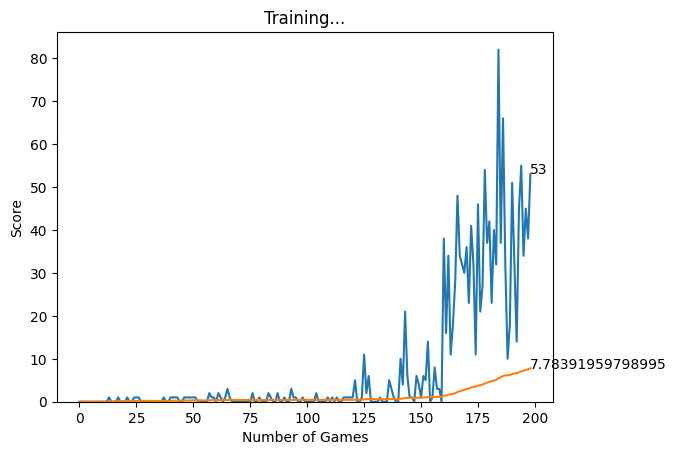

In [ ]:
if __name__ == '__main__':
    train()